## This jupyter notebook shows how spectral representation is used during frequency dropout compared to max pooling

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from modules.SpectralPool import max_pool, max_pool_1, l2_loss_images, l2_loss_images_1
from modules.FrequencyDropout import freq_dropout_test
from modules.CreateImages import open_image, downscale_image
from modules.Utils import load_cifar10
np.set_printoptions(precision=3, linewidth=200)
# Set printing options: precision for floating point output; 
# The number of characters per line for the purpose of inserting line breaks
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
images, _ = load_cifar10(1, get_test_data=False)
print('Shape of input images:',images.shape)

file already downloaded..
getting batch 1
Shape of input images: (10000, 32, 32, 3)


In [1]:
pwd

'/home/ecbm4040/Spectral_Representation_for_CNN'

## First, show how the quality becomes vague as frequency dropout is applied.

Cut_off = 16


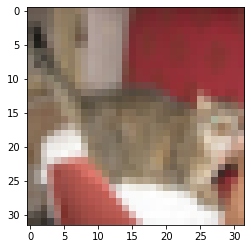

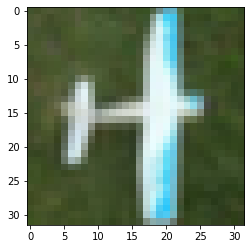

Cut_off = 14


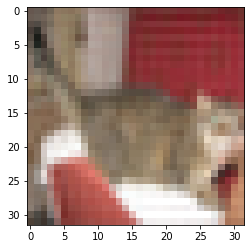

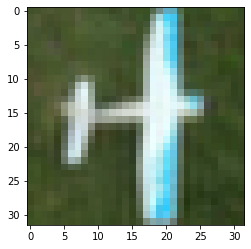

Cut_off = 12


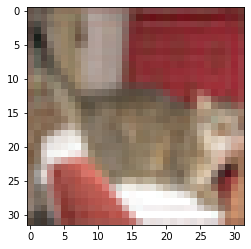

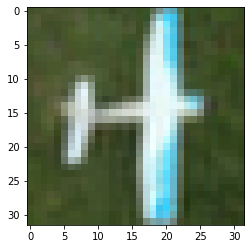

Cut_off = 10


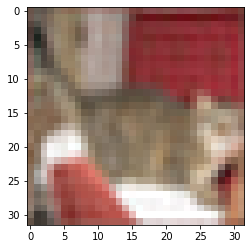

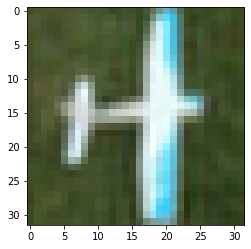

Cut_off = 8


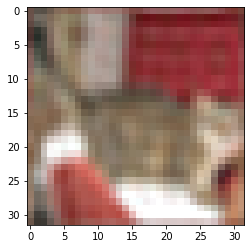

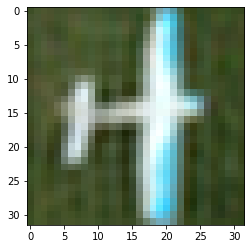

Cut_off = 6


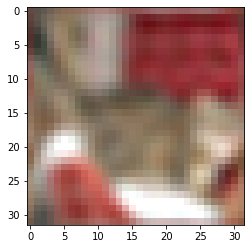

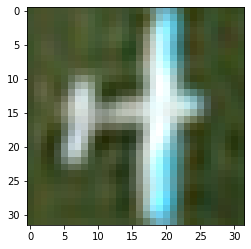

Cut_off = 4


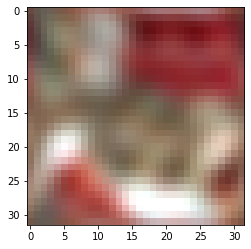

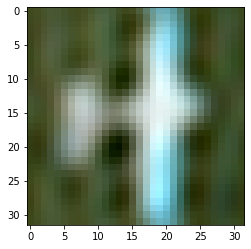

Cut_off = 2


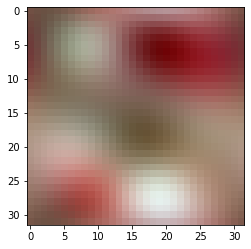

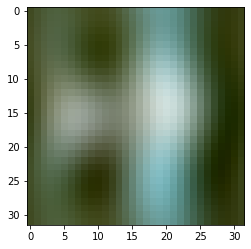

In [6]:
batch_size = 2
random_select_indices_pic = np.random.choice(len(images), size=batch_size)
# Cutoff means the border of when the freqency is dropped
for cut_off in range(16,1,-2):
    # first randomly take a minibatch of pictures for implementing frequency dropout
    minibatch_cut_off = tf.cast(tf.constant(cut_off), dtype=tf.float32)
    random_selection = images[random_select_indices_pic]
    downsampled_images = np.moveaxis(freq_dropout_test(random_selection, minibatch_cut_off), 1, 3)                                           
    print('Cut_off = {0}'.format(cut_off))
    for i in range(batch_size):
        # Display data as an image, i.e., on a 2D regular poster.
        plt.imshow(np.clip(downsampled_images[i],0,1), cmap='gray')
        plt.show()
# we can see in different cut_off value, the degrades is different.

### Second, show how the random cutoff is applied to image batches

Minibatch number 1


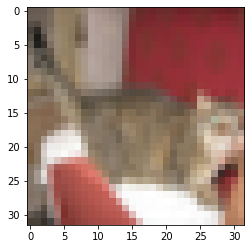

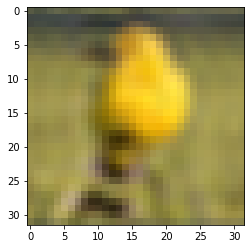

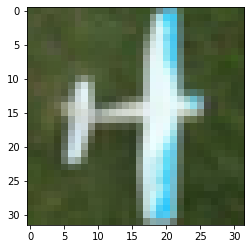

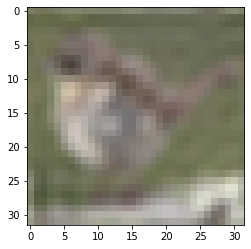

Minibatch number 2


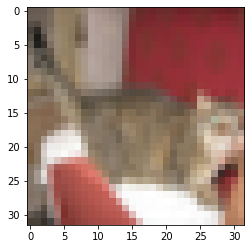

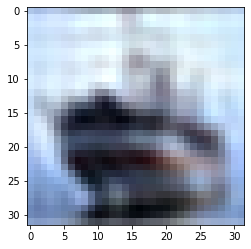

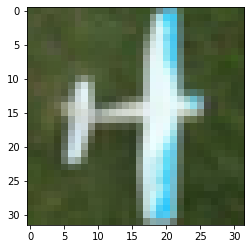

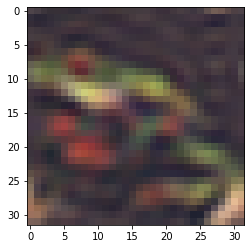

Minibatch number 3


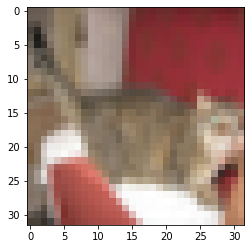

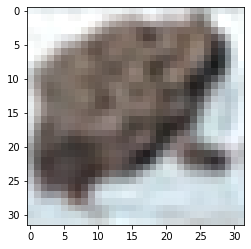

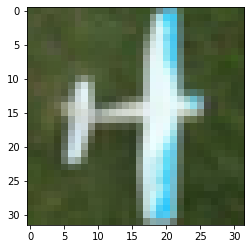

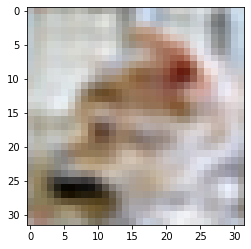

In [7]:
batch_size = 2
minibatch_cut_off = tf.random.uniform([], 2, 12)
# first randomly take a minibatch of pictures for implementing frequency dropout
for iter_index in range(3):
    random_select_indices_pic = np.random.choice(len(images), size=batch_size)
    random_select = images[random_select_indices_pic]
    downsampled_images = np.moveaxis(freq_dropout_test(random_select, minibatch_cut_off),1,3) 
    print('Minibatch number {0}'.format(iter_index + 1))
    for i in range(batch_size):
        plt.imshow(random_selection[i], cmap='gray')
        plt.show()
        plt.imshow(np.clip(downsampled_images[i],0,1), cmap='gray')
        plt.show()
# We can see the frequency could change among a flow in different pictures.

### When using max pool to certain picture

In [3]:
'''
If failed by gpu memory problem, please shutdown and  restart the notebook.
'''

# from image pool select one picture
images_pool = max_pool(images, 2)
# with tf.compat.v1.Session() as sess:
#     images_pool = sess.run(images_pool_1)
print('Shape of images_tool:',images_pool.shape)

Shape of images_tool: (10000, 31, 31, 3)


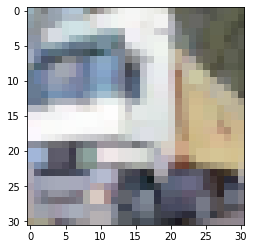

In [4]:
# use maxpoolng to peocess the picture
plt.imshow(images_pool[1], cmap='gray')
# we can see that the picture's feature is vague

### When using spectral pool to certain picture

In [5]:
# set cut off frequency
cut_off_frequency = int(32 / (2 * 2))
# change the cut off frequency to make it shift from pis to pics
tf_cut_off_frequency = tf.cast(tf.constant(cut_off_frequency), tf.float32)
# perform spectral pool on the pictures
images_spectral_pool = np.clip(np.moveaxis(freq_dropout_test(images, tf_cut_off_frequency), 1, 3), 0, 1)
# we can see in the picture, the feature was well reserved after pooling
print('Shape of images_spectral_pool:',images_spectral_pool.shape)

Shape of images_spectral_pool: (10000, 32, 32, 3)


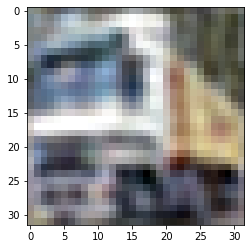

In [6]:
plt.imshow(images_spectral_pool[1], cmap='gray')

## Check the loss of max pool and spectral pool and plot the results

In [7]:
# Take some samples from image input
images_sample = images[np.random.choice(len(images), size=256)]

In [8]:
# calculate losses for max_pool:
pool_size_mp = [2, 4, 8, 16, 32]
# initilialize the error pool
max_pool_errors = []
# use different maxpooling size to perform maxpooling
for s in pool_size_mp:
    # define the loss of sampled image
    images_pool = max_pool_1(images_sample, s)
    loss = l2_loss_images_1(images_sample, images_pool)
    max_pool_errors.append(loss)

In [9]:
# calculate losses for spectral_pool:
filter_size_sp = np.arange(16)
# initilialize the error pool for dipicting
spec_pool_errors = []
# use different maxpooling size to perform spectral pooling
for s in filter_size_sp:
    tf_cutoff_freq = tf.cast(tf.constant(s), tf.float32)
    # define the loss of sampled image
    images_sp = np.moveaxis(freq_dropout_test(images_sample,tf_cutoff_freq), 1, 3)
    loss = l2_loss_images(images_sample, images_sp)
    spec_pool_errors.append(loss)

In [10]:
# set the fraction of pool kernel size
pool_frac_kept = [1/x**2 for x in pool_size_mp]
sp_frac_kept = [(x/16)**2 for x in filter_size_sp] 

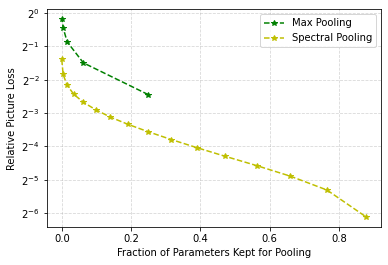

In [12]:
# Create a figure and a set of subplots.
fig, axes = plt.subplots(1, 1)
# semilogy(X,Y) plots x- and y-coordinates using a linear scale on the x-axis and a base-10 logarithmic scale on the y-axis.
axes.semilogy(pool_frac_kept, max_pool_errors, base=2,
            marker='*', linestyle='--', color='g', label='Max Pooling')
axes.semilogy(sp_frac_kept, spec_pool_errors, base=2,
            marker='*', linestyle='--', color='y', label='Spectral Pooling')
# set legend and other properties
axes.legend()
axes.grid(linestyle='--', alpha=0.5)
axes.set_xlabel('Fraction of Parameters Kept for Pooling')
axes.set_ylabel('Relative Picture Loss')
fig.savefig('Figure4_Approximation_Loss.png')